## 1. Inital setup and Data collection

In [1]:
'''required library/dependencies'''
import os, time, uuid, cv2, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
'''Avoid OOM errors by setting GPU Memory Consumption Growth'''
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.1 Run annotaion tool to draw bounding boxes around the face.

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [6]:
'''run annotation tool to draw bounding boxes around the area of interest'''
# !labelme

### 1.2 Load images into tensorflow data pipeline

In [7]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

images.as_numpy_iterator().next()

b'data\\images\\85a1f821-3155-11ee-ac64-b88198d6e75e.jpg'

In [8]:
'''function to read image file and covert into an array'''
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

images = images.map(load_image)

## 2. Partition of data

- Split the data (images) manually into train, test and val folders.
- labels can be moved using the following code.

In [9]:
'''move labels into respective train, test and val folders'''
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)    

## 3. Data Augmentation

In [10]:
import albumentations as alb

In [11]:
'''creating an instance of albumentation'''
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 3.1 Test augmentor on a single image

In [30]:
# Load any sample image from our data
img = cv2.imread(os.path.join('data','train', 'images','8f7b4c8a-3155-11ee-84d4-b88198d6e75e.jpg'))

# load the respective label of the image.
with open(os.path.join('data', 'train', 'labels', '8f7b4c8a-3155-11ee-84d4-b88198d6e75e.json'), 'r') as f:
    label = json.load(f)

In [31]:
# co-ordinates of annotation
print(label['shapes'][0]['points'])

# extract the co-ordinates
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

coords

[[5.937499999999986, 215.26041666666663], [136.14583333333331, 375.15625]]


[5.937499999999986, 215.26041666666663, 136.14583333333331, 375.15625]

In [32]:
# scaling down co-ordinates to use with albumentations
coords = list(np.divide(coords, [640,480,640,480]))

# scaled co-ordinates of annotation
coords

[0.009277343749999977,
 0.4484592013888888,
 0.21272786458333331,
 0.7815755208333334]

In [33]:
# apply our augmentation
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
# view the augmented image with bounding box
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### 3.2 Combine all the steps in 3.1 and build a pipeline

In [35]:
# runs augmentor on all the images and stores newly transformed data in aug_data folder.
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 3.3 Split augmented data (Both images and labels)

In [36]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False) # file path
train_images = train_images.map(load_image) # loading image and convert to array
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120))) # resizing for better performance
train_images = train_images.map(lambda x: x/255) # scaling between 0 and 1

In [37]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [38]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [39]:
# function to return the label 0 or 1 (classification) and bounding box values(regression)
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [40]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False) # file path
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16])) # returns class and bounding box co-ords

In [41]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2520, 2520, 540, 540, 540, 540)

### 3.4 Final Dataset

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [45]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [46]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### 3.5 Check augmented data

In [47]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## 4. Building Model

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 4.1 Download vgg16 (transfer learning)

In [51]:
vgg = VGG16(include_top=False)

In [52]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 4.2 Create Model network (classification + regression)

In [53]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [54]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [55]:
X, y = train.as_numpy_iterator().next()

In [56]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 1s 545ms/step


(array([[0.49380097],
        [0.59481525],
        [0.61312425],
        [0.46459678],
        [0.55840826],
        [0.50237405],
        [0.4847562 ],
        [0.572202  ]], dtype=float32),
 array([[0.5297267 , 0.50309265, 0.5362753 , 0.443415  ],
        [0.42222106, 0.49341166, 0.44524273, 0.5100209 ],
        [0.42217004, 0.5302936 , 0.5052643 , 0.43300402],
        [0.4495308 , 0.5381328 , 0.50678444, 0.42610723],
        [0.4382413 , 0.4787153 , 0.48852107, 0.4115505 ],
        [0.44817472, 0.5086799 , 0.5025707 , 0.47549552],
        [0.44271103, 0.5907929 , 0.46434054, 0.5350283 ],
        [0.4918267 , 0.5716737 , 0.5160297 , 0.34895334]], dtype=float32))

## 5. Define losses and optimizers

### 5.1 Learning rate

In [57]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [58]:
# optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 5.2 Localization loss and Classification loss

In [59]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [60]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 5.3 Test loss metrics

In [61]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.2009773>

In [62]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6292933>

## 6. Train Neural Network

### 6.1 Create a facetracker class

In [63]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [64]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

### 6.2 Train

In [65]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [66]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
315/315 [==============================] - 295s 891ms/step - total_loss: 0.5794 - class_loss: 0.1768 - regress_loss: 0.4910 - val_total_loss: 0.0733 - val_class_loss: 0.0076 - val_regress_loss: 0.0695
Epoch 2/10
315/315 [==============================] - 293s 903ms/step - total_loss: 0.0895 - class_loss: 0.0202 - regress_loss: 0.0794 - val_total_loss: 0.0649 - val_class_loss: 1.8107e-04 - val_regress_loss: 0.0648
Epoch 3/10
315/315 [==============================] - 294s 907ms/step - total_loss: 0.0443 - class_loss: 0.0095 - regress_loss: 0.0395 - val_total_loss: 0.0319 - val_class_loss: 0.0026 - val_regress_loss: 0.0306
Epoch 4/10
315/315 [==============================] - 296s 913ms/step - total_loss: 0.0242 - class_loss: 0.0056 - regress_loss: 0.0214 - val_total_loss: 0.0599 - val_class_loss: 0.0212 - val_regress_loss: 0.0493
Epoch 5/10
315/315 [==============================] - 297s 917ms/step - total_loss: 0.0179 - class_loss: 0.0038 - regress_loss: 0.0160 - val_total_l

In [67]:
hist.history

{'total_loss': [0.05180421099066734,
  0.02207132987678051,
  0.014039942063391209,
  0.024914879351854324,
  0.013945800252258778,
  0.005066222045570612,
  0.004017786588519812,
  0.0029815309680998325,
  0.002826011274009943,
  0.004081555176526308],
 'class_loss': [0.004286951385438442,
  0.002518333960324526,
  0.00011422331590438262,
  0.0001208636604133062,
  0.00033752137096598744,
  0.0007646302110515535,
  1.6607653378741816e-05,
  2.6942285330733284e-05,
  4.007864845334552e-05,
  7.497399928979576e-05],
 'regress_loss': [0.049660734832286835,
  0.02081216312944889,
  0.013982830569148064,
  0.024854447692632675,
  0.01377703994512558,
  0.004683907143771648,
  0.00400948291644454,
  0.002968059852719307,
  0.0028059720061719418,
  0.004044068045914173],
 'val_total_loss': [0.07326371222734451,
  0.06486192345619202,
  0.03194306790828705,
  0.05989079177379608,
  0.031521037220954895,
  0.03374078869819641,
  0.0012817176757380366,
  0.012524105608463287,
  0.02738062106072

### 6.3 Plot Performance

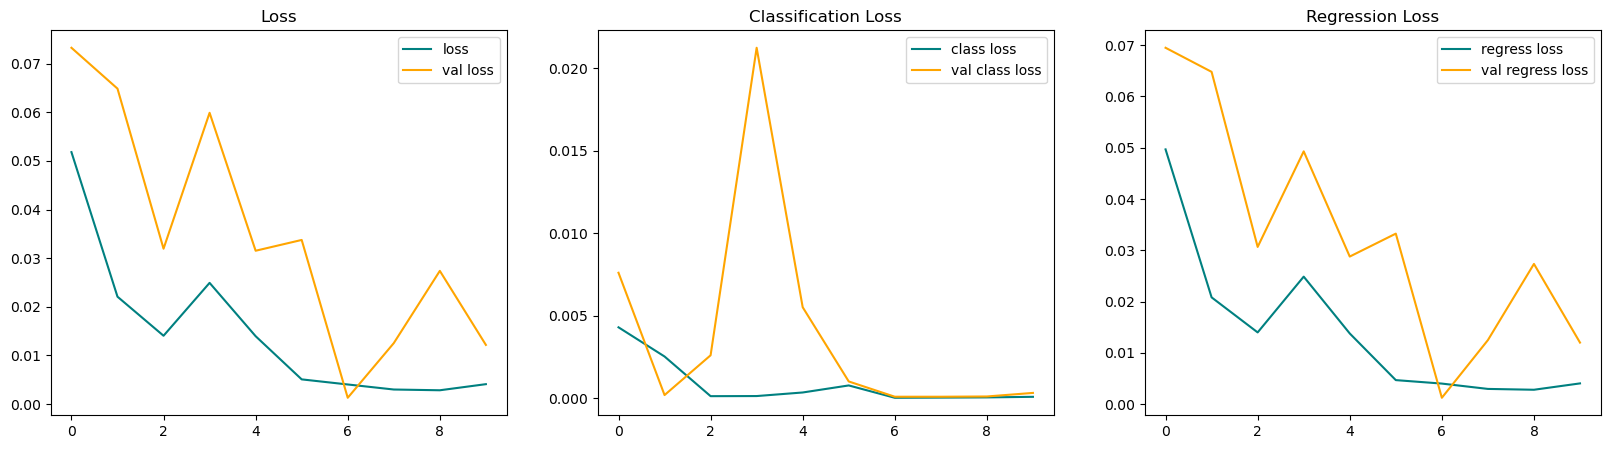

In [68]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### 6.4 Test

In [69]:
test_data = test.as_numpy_iterator()


In [70]:
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 31ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 6.5 Save Model

In [72]:
from tensorflow.keras.models import load_model

facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

## 7. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()